In [1]:
import os
import utils
import model_scoring
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"  # or choose another backend if you wish
import pandas as pd
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, DatetimeTickFormatter
from bokeh.models.tools import HoverTool
from bokeh.io.export import get_screenshot_as_png
from bokeh.io import output_notebook
import sklearn
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import datetime
import keras
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, Input

Using plaidml.keras.backend backend.


In [2]:
output_notebook()

Loading BokehJS ...

In [181]:
train, test = utils.load_data()

Now, we will normalize the data.

In [182]:
mean = train.mean(axis=0)
std = train.std(axis=0)

utils.preprocess(train, mean, std)
utils.preprocess(test, mean, std)

In [183]:
labels = train['target'].tolist()
train.drop(columns=['target'], inplace=True)
train.head()

,t_max,t_avg,t_min,dwpt_max,dwpt_avg,dwpt_min,rh_max,rh_avg,rh_min,ws_max,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2005-03-03,-1.639354,-1.612209,-1.542667,-1.896907,-1.657581,-1.120476,-1.118399,-0.875393,-0.430303,1.391104,...,1,0,0,0,0,0,0,0,0,0
2016-01-16,-0.651542,-0.625509,-0.484166,-0.364984,-0.228895,-0.117802,1.047298,0.872425,0.432938,-0.033256,...,0,0,0,0,0,0,0,0,0,0
2015-06-05,0.281392,0.221893,0.280307,0.429347,0.525883,0.702568,0.370518,0.759017,1.296179,-1.101526,...,0,0,0,1,0,0,0,0,0,0
2010-08-17,1.488718,1.562646,1.574031,1.450629,1.280660,0.930449,0.370518,-0.248313,-0.828721,-0.923481,...,0,0,0,0,0,1,0,0,0,0
2011-09-28,0.665541,0.860347,1.044780,1.166939,1.339964,1.431786,1.182654,1.606243,1.960211,-0.211301,...,0,0,0,0,0,0,1,0,0,0


In [212]:
main_input = Input(shape=(train.shape[1],), name='main_input')

x = Dense(128, activation='relu')(main_input)
x = Dropout(.25)(x)
x = Dense(8, activation='relu')(x)

output = Dense(1, name='output')(x)

model = Model(inputs=[main_input], outputs=output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 454)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 128)               58240     
_________________________________________________________________
dropout_30 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 8)                 1032      
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 59,281
Trainable params: 59,281
Non-trainable params: 0
_________________________________________________________________


In [213]:
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])
history = model.fit([train], labels,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                   )

Train on 3970 samples, validate on 993 samples
Epoch 1/10
3970/3970 [==============================] - 0s 123us/step - loss: 0.4558 - mean_absolute_error: 0.4726 - val_loss: 0.1277 - val_mean_absolute_error: 0.2667
Epoch 2/10
3970/3970 [==============================] - 0s 124us/step - loss: 0.1536 - mean_absolute_error: 0.2858 - val_loss: 0.0938 - val_mean_absolute_error: 0.2265
Epoch 3/10
3970/3970 [==============================] - 0s 118us/step - loss: 0.1243 - mean_absolute_error: 0.2564 - val_loss: 0.0812 - val_mean_absolute_error: 0.2080
Epoch 4/10
3970/3970 [==============================] - 0s 119us/step - loss: 0.1091 - mean_absolute_error: 0.2390 - val_loss: 0.0773 - val_mean_absolute_error: 0.2044
Epoch 5/10
3970/3970 [==============================] - 0s 117us/step - loss: 0.0921 - mean_absolute_error: 0.2214 - val_loss: 0.0751 - val_mean_absolute_error: 0.2027
Epoch 6/10
3970/3970 [==============================] - 0s 122us/step - loss: 0.0898 - mean_absolute_error: 0.217

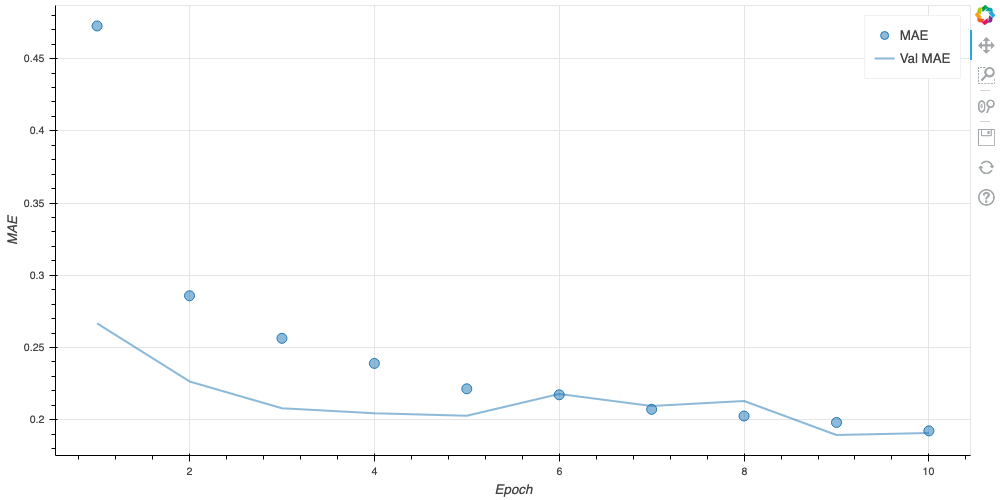

In [214]:
source = pd.DataFrame(history.history)
source['epoch'] = source.index + 1
acc_plot = figure(plot_width=1000, plot_height=500, x_axis_label='Epoch', y_axis_label='MAE')
acc_plot.circle(x='epoch', y='mean_absolute_error', source=source, size=10, fill_alpha=.5, legend_label='MAE')
acc_plot.line(x='epoch', y='val_mean_absolute_error', source=source, line_width=2, legend_label='Val MAE', alpha=0.5)
# show(acc_plot)
get_screenshot_as_png(acc_plot, driver=None)

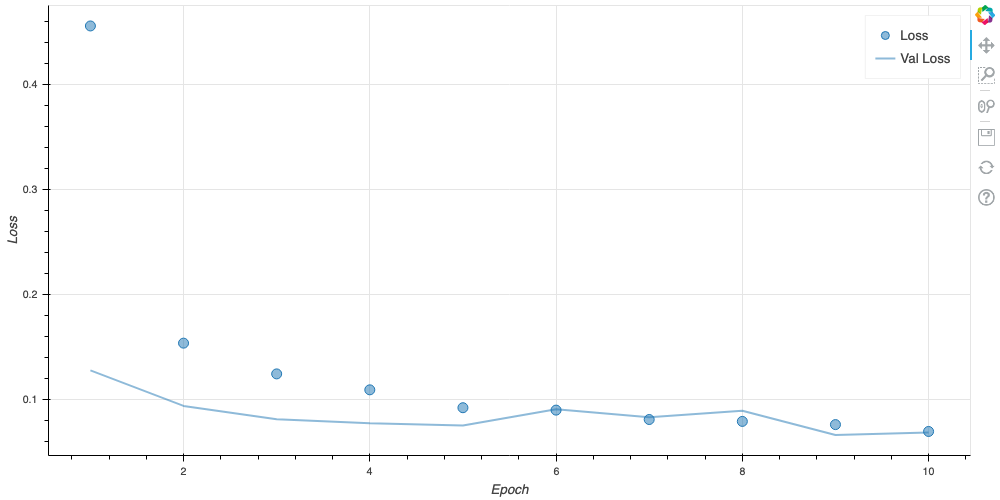

In [215]:
loss_plot = figure(plot_width=1000, plot_height=500, x_axis_label='Epoch', y_axis_label='Loss')
loss_plot.circle(x='epoch', y='loss', source=source, size=10, fill_alpha=.5, legend_label='Loss')
loss_plot.line(x='epoch', y='val_loss', source=source, line_width=2, legend_label='Val Loss', alpha=0.5)
# show(loss_plot)
get_screenshot_as_png(loss_plot, driver=None)

Previously achieved with NOAA weather data:  
  
Total prediction error: 113288.0  
Total ISOLF prediction error: 63146.0  
Percentage of time the model outperformed the NYISO model: 31.76 (175/551)  

In [216]:
predictions = model.predict(test.copy().drop(columns=['target']))
isolf = utils.isolf()
results = test.join(isolf, how='inner')
results['prediction'] = predictions
results['target'] *= std.target
results['target'] += mean.target
results['prediction'] *= std.target
results['prediction'] += mean.target
results['date'] = results.index
results = results.astype({'prediction': 'float'})

results, pred_plot = model_scoring.eval(results)

Total prediction error: 97309.0
Total ISOLF prediction error: 62816.0
Percentage of time the model outperformed the NYISO model: 38.29 (211/551)


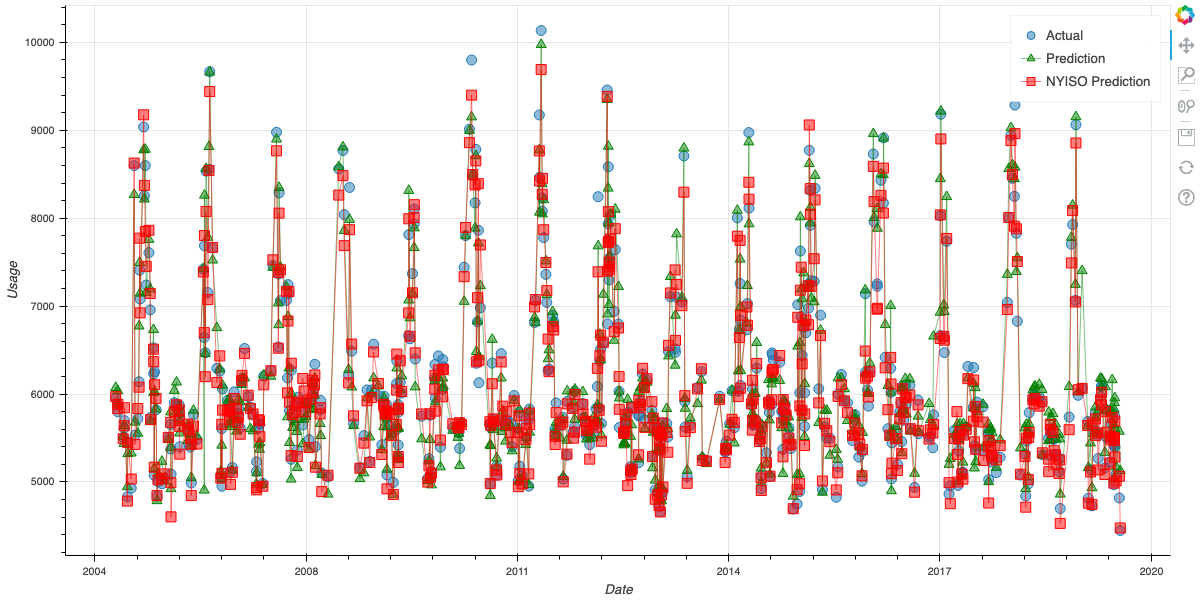

In [217]:
# show(pred_plot)
get_screenshot_as_png(pred_plot, driver=None)

In [218]:
results

,target,t_max,t_avg,t_min,dwpt_max,dwpt_avg,dwpt_min,rh_max,rh_avg,rh_min,...,month_8,month_9,month_10,month_11,month_12,nyiso_prediction,prediction,date,prediction_error,nyiso_prediction_error
2006-07-02,6642.901365,-0.596664,-0.248241,0.103890,-1.102576,-1.468887,-1.485085,-1.998213,-1.108881,-0.164690,...,0,0,0,0,0,6699.208333,4906.000000,2006-07-02,-1736.901365,56.306968
2007-10-09,7144.031142,1.104569,0.767481,0.633141,1.053464,0.930228,0.793720,0.505874,0.552214,0.632148,...,0,0,1,0,0,7164.708333,6294.541016,2007-10-09,-849.490126,20.677191
2018-08-30,9287.070470,1.488718,1.713553,1.750448,1.450629,1.431616,1.340634,-0.306262,-0.341708,-0.231093,...,1,0,0,0,0,8962.333333,8579.840820,2018-08-30,-707.229649,-324.737136
2010-07-06,9799.167586,2.147259,2.090821,1.868059,1.166939,1.313008,1.295058,-1.118399,-1.208947,-1.094334,...,0,0,0,0,0,9400.166667,9151.425781,2010-07-06,-647.741805,-399.000920
2007-08-14,7365.939236,1.104569,1.214398,1.221197,0.429347,0.450405,0.474688,-1.930535,-1.475789,-1.160737,...,1,0,0,0,0,7382.583333,6787.571289,2007-08-14,-578.367947,16.644097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-12,6828.020962,0.775298,1.017058,1.280003,1.450629,1.609528,1.705243,1.385688,2.026520,2.624242,...,0,1,0,0,0,7506.916667,7548.595703,2018-09-12,720.574741,678.895704
2020-03-24,4818.006552,-0.541785,-0.712570,-0.778194,-0.762149,-0.498458,-0.117802,0.370518,0.232003,0.100923,...,0,0,0,0,0,5064.791667,5575.962891,2020-03-24,757.956339,246.785115
2016-08-05,7253.401034,1.214326,1.278244,1.280003,0.939988,1.091966,1.203905,-0.712331,-0.254984,0.034519,...,1,0,0,0,0,6965.416667,8108.680664,2016-08-05,855.279630,-287.984368
2017-06-10,5764.069097,1.378961,1.318873,1.044780,0.713036,0.682230,0.793720,-1.389111,-1.202275,-0.895125,...,0,0,0,0,0,5653.208333,6657.875000,2017-06-10,893.805903,-110.860764
